In [36]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

In [2]:
def Map_CONUS(row,col,num,londata,latdata):
    extent = [360-120, 360-70, 20, 55]
    central_lon,central_lat=360-96,38
    ax = plt.subplot(row,col,num,projection=ccrs.AlbersEqualArea(central_lon, central_lat))
    #ax = plt.subplot(row,col,num,projection=ccrs.PlateCarree(central_longitude=cen_lon))
    ax.coastlines('50m')
    ax.add_feature(cartopy.feature.STATES,edgecolor='gray')
    ax.set_extent(extent)
    x,y=np.meshgrid(londata,latdata)

    return ax,x,y
PC = ccrs.PlateCarree(central_longitude=0)

In [37]:
# spatial smoother
def gaussfilter(data,stddev):
    
    lat,lon = np.shape(data)
    
    data_smooth = np.empty(data.shape,dtype=float)
    
    data_tmp = data
    kernel = Gaussian2DKernel(stddev)
    data_smooth = convolve(data_tmp, kernel)

    return data_smooth

In [285]:
lat = np.arange(-90,90,1)
lon = np.arange(-180,180,1)
#print(lat)

In [286]:
# tornado data
torndata = pd.read_csv('../_data/1950-2019_torn.csv')
#torndata

In [287]:
# only care about spring 1985-2019
torndata_MAM = torndata[torndata['mo']>2]
torndata_MAM = torndata_MAM[torndata_MAM['mo']<6]
torndata_MAM = torndata_MAM[torndata_MAM['yr']>1984]
torndata_MAM = torndata_MAM[torndata_MAM['yr']<2020]
torndata_MAM.shape

(17731, 29)

In [288]:
# get latitude column
torndata_MAM_slat,torndata_MAM_elat = torndata_MAM['slat'],torndata_MAM['elat']
print(torndata_MAM_slat.shape)

(17731,)


In [289]:
# get longitude column
torndata_MAM_slon,torndata_MAM_elon = torndata_MAM['slon'],torndata_MAM['elon']
print(torndata_MAM_slon.shape)

(17731,)


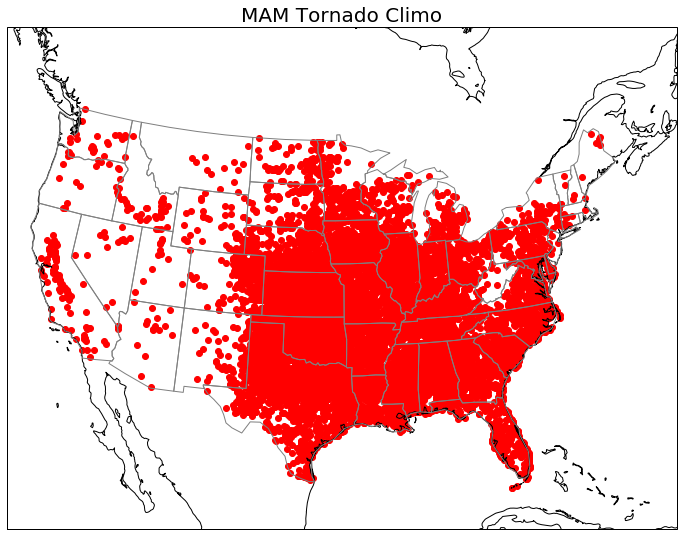

In [290]:
fig = plt.figure(figsize=[12,12])

ax1,x,y = Map_CONUS(1,1,1,lon,lat)
#for idx in range(len(torndata_MAM_slon)):
#ax1.plot([torndata_MAM_slon.values[idx],torndata_MAM_elon.values[idx]],[torndata_MAM_slat.values[idx],torndata_MAM_elat.values[idx]],color='r',transform=PC)
ax1.scatter(torndata_MAM_elon,torndata_MAM_elat,color='r',transform=PC)
ax1.set_title('MAM Tornado Climo',fontsize=20)

plt.show()

In [291]:
# count how many events have occured within 1x1 deg box
counts = np.zeros((92,len(lon),len(lat)))
print(counts.shape)

(92, 360, 180)


In [292]:
for idx in range(len(torndata_MAM_slat)):
    #print(idx)
    month = torndata_MAM['mo'].values[idx]-3
    day = torndata_MAM['dy'].values[idx]
            
    slat,slon = round(torndata_MAM_slat.values[idx]),round(torndata_MAM_slon.values[idx])
    elat,elon = round(torndata_MAM_elat.values[idx]),round(torndata_MAM_elon.values[idx])

    if slon == 0.0:
        lonpts=[elon]
        latpts=[elat]
    elif elon == 0.0:
        lonpts=[slon]
        latpts=[slat]
    else:
        #dist = np.sqrt((elon-slon)**2 + (elat-slat)**2)
        #if round(dist) >= 2:
        lonpts=[slon,elon]
        latpts=[slat,elat]

    lonpts_count = np.array(lonpts)+180 # get index
    latpts_count = np.array(latpts)+90 # get index

    for vals in range(len(lonpts_count)):
        i,j = int(lonpts_count[vals]),int(latpts_count[vals])
        if month==0:
            counts[day,i,j] = counts[day,i,j] + 1
        if month==1:
            counts[day+31,i,j] = counts[day+31,i,j] + 1
        else:
            counts[day+60,i,j] = counts[day+60,i,j] + 1


In [293]:
counts = counts/(2020-1985)

In [294]:
counts.mean()

0.00017814009661835757

In [295]:
counts_tfilt = np.empty(counts.shape)
for ii in range(len(lon)):
    if ii%50==0:
        print(ii)
    for jj in range(len(lat)):
        counts_tfilt[:,ii,jj] = np.array(pd.Series(counts[:,ii,jj]).rolling(15).mean())

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350


In [296]:
countsmean = np.nanmean(counts_tfilt,axis=0)*100

In [297]:
countsmean.max()

10.244200244200247

In [298]:
counts_spatialfilt = gaussfilter(countsmean,2)
counts_spatialfilt[counts_spatialfilt<0.2]=np.nan

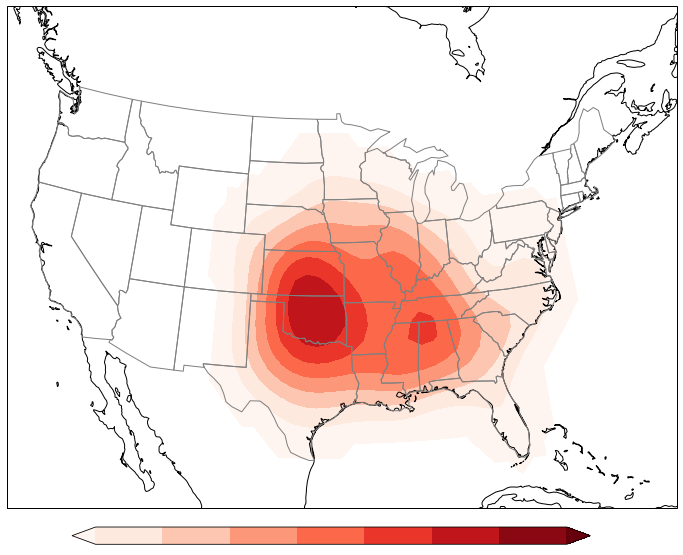

In [299]:
fig = plt.figure(figsize=[12,12])

ax1,x,y = Map_CONUS(1,1,1,lon,lat)
cs=ax1.contourf(x,y,np.transpose(counts_spatialfilt),np.linspace(1,6,8),cmap='Reds',transform=PC,extend='both')
# ax1.text(.4, 0.85, 'Average relative tornado\nprobability in MAM', va='bottom', ha='center',
#         rotation='horizontal',fontsize=24,transform=ax1.transAxes)

cbaxes = fig.add_axes([0.2, 0.17, 0.6, 0.02])
cb = plt.colorbar(cs,orientation='horizontal', cax=cbaxes)
cb.set_ticks([])
# cb.ax.set_xlabel('m s$^-$$^1$',fontsize=16)
# cb.ax.tick_params(labelsize=14)

plt.show()

In [300]:
lat = np.arange(-90,90,1)
lon = np.arange(-180,180,1)
#print(lat)

In [301]:
# hail data
haildata = pd.read_csv('../_data/1955-2019_hail.csv')


In [302]:
# only care about spring 1985-2019
haildata_MAM = haildata[haildata['mo']>2]
haildata_MAM = haildata_MAM[haildata_MAM['mo']<6]
haildata_MAM = haildata_MAM[haildata_MAM['yr']>1984]
haildata_MAM = haildata_MAM[haildata_MAM['yr']<2020]
haildata_MAM.shape

(153383, 28)

In [303]:
# get latitude column
haildata_MAM_slat,haildata_MAM_elat = haildata_MAM['slat'],haildata_MAM['elat']
print(haildata_MAM_slat.shape)

(153383,)


In [304]:
# get longitude column
haildata_MAM_slon,haildata_MAM_elon = haildata_MAM['slon'],haildata_MAM['elon']
print(haildata_MAM_slon.shape)

(153383,)


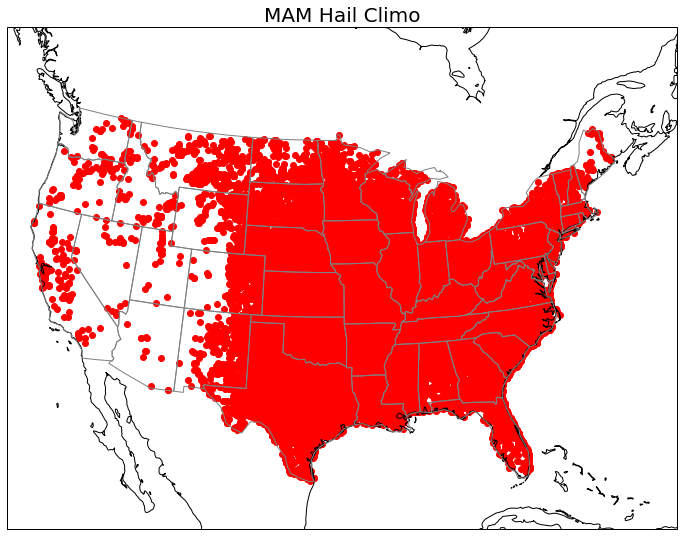

In [305]:
fig = plt.figure(figsize=[12,12])

ax1,x,y = Map_CONUS(1,1,1,lon,lat)
#for idx in range(len(torndata_MAM_slon)):
#ax1.plot([torndata_MAM_slon.values[idx],torndata_MAM_elon.values[idx]],[torndata_MAM_slat.values[idx],torndata_MAM_elat.values[idx]],color='r',transform=PC)
ax1.scatter(haildata_MAM_elon,haildata_MAM_elat,color='r',transform=PC)
ax1.set_title('MAM Hail Climo',fontsize=20)

plt.show()

In [306]:
# count how many events have occured within 1x1 deg box
counts = np.zeros((92,len(lon),len(lat)))
print(counts.shape)

(92, 360, 180)


In [307]:
for idx in range(len(haildata_MAM_slat)):
    #print(idx)
    month = haildata_MAM['mo'].values[idx]-3
    day = haildata_MAM['dy'].values[idx]
            
    slat,slon = round(haildata_MAM_slat.values[idx]),round(haildata_MAM_slon.values[idx])
    elat,elon = round(haildata_MAM_elat.values[idx]),round(haildata_MAM_elon.values[idx])

    if slon == 0.0:
        lonpts=[elon]
        latpts=[elat]
    elif elon == 0.0:
        lonpts=[slon]
        latpts=[slat]
    else:
        #dist = np.sqrt((elon-slon)**2 + (elat-slat)**2)
        #if round(dist) >= 2:
        lonpts=[slon,elon]
        latpts=[slat,elat]

    lonpts_count = np.array(lonpts)+180 # get index
    latpts_count = np.array(latpts)+90 # get index

    for vals in range(len(lonpts_count)):
        i,j = int(lonpts_count[vals]),int(latpts_count[vals])
        if month==0:
            counts[day,i,j] = counts[day,i,j] + 1
        if month==1:
            counts[day+31,i,j] = counts[day+31,i,j] + 1
        else:
            counts[day+60,i,j] = counts[day+60,i,j] + 1


In [308]:
counts = counts/(2020-1985)

In [309]:
counts.mean()

0.001205136684303351

In [310]:
counts_tfilt = np.empty(counts.shape)
for ii in range(len(lon)):
    if ii%50==0:
        print(ii)
    for jj in range(len(lat)):
        counts_tfilt[:,ii,jj] = np.array(pd.Series(counts[:,ii,jj]).rolling(15).mean())

0
50
100
150
200
250
300
350


In [311]:
countsmean = np.nanmean(counts_tfilt,axis=0)*100

In [312]:
countsmean.max()

99.56043956043959

In [313]:
counts_spatialfilt = gaussfilter(countsmean,2)
counts_spatialfilt[counts_spatialfilt<0.2]=np.nan

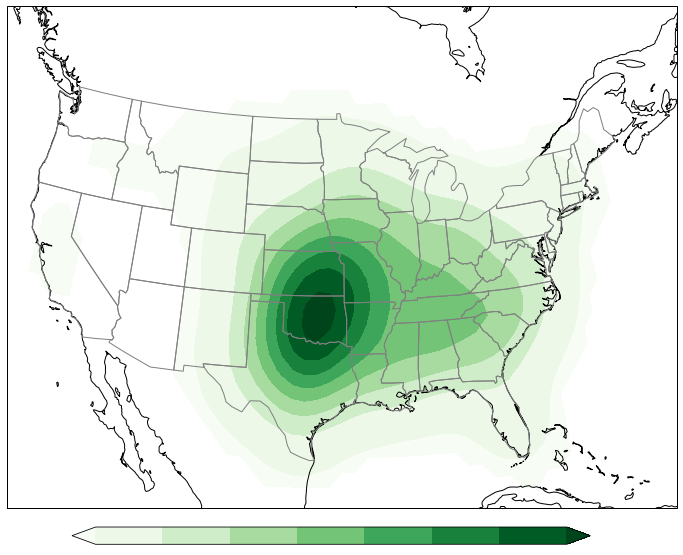

In [321]:
fig = plt.figure(figsize=[12,12])

ax1,x,y = Map_CONUS(1,1,1,lon,lat)
cs=ax1.contourf(x,y,np.transpose(counts_spatialfilt),np.linspace(1,38,8),cmap='Greens',transform=PC,extend='both')
# ax1.text(.4, 0.85, 'Average relative tornado\nprobability in MAM', va='bottom', ha='center',
#         rotation='horizontal',fontsize=24,transform=ax1.transAxes)

cbaxes = fig.add_axes([0.2, 0.17, 0.6, 0.02])
cb = plt.colorbar(cs,orientation='horizontal', cax=cbaxes)
cb.set_ticks([])
# cb.ax.set_xlabel('m s$^-$$^1$',fontsize=16)
# cb.ax.tick_params(labelsize=14)

plt.show()

In [244]:
lat = np.arange(-90,90,1)
lon = np.arange(-180,180,1)
#print(lat)

In [245]:
# wind data
winddata = pd.read_csv('../_data/1955-2019_wind.csv')


C:\Users\kelse\Anaconda3\envs\LB_20190503\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [246]:
# only care about spring 1985-2019
winddata_MAM = winddata[winddata['mo']>2]
winddata_MAM = winddata_MAM[winddata_MAM['mo']<6]
winddata_MAM = winddata_MAM[winddata_MAM['yr']>1984]
winddata_MAM = winddata_MAM[winddata_MAM['yr']<2020]
winddata_MAM.shape

(101625, 29)

In [247]:
# get latitude column
winddata_MAM_slat,winddata_MAM_elat = winddata_MAM['slat'],winddata_MAM['elat']
print(winddata_MAM_slat.shape)

(101625,)


In [248]:
# get longitude column
winddata_MAM_slon,winddata_MAM_elon = winddata_MAM['slon'],winddata_MAM['elon']
print(winddata_MAM_slon.shape)

(101625,)


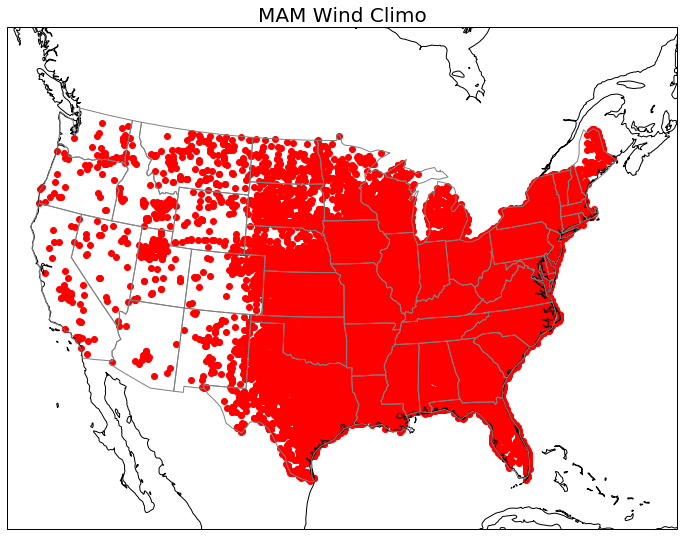

In [249]:
fig = plt.figure(figsize=[12,12])

ax1,x,y = Map_CONUS(1,1,1,lon,lat)
#for idx in range(len(torndata_MAM_slon)):
#ax1.plot([torndata_MAM_slon.values[idx],torndata_MAM_elon.values[idx]],[torndata_MAM_slat.values[idx],torndata_MAM_elat.values[idx]],color='r',transform=PC)
ax1.scatter(winddata_MAM_elon,winddata_MAM_elat,color='r',transform=PC)
ax1.set_title('MAM Wind Climo',fontsize=20)

plt.show()

In [250]:
# count how many events have occured within 1x1 deg box
counts = np.zeros((92,len(lon),len(lat)))
print(counts.shape)

(92, 360, 180)


In [251]:
for idx in range(len(winddata_MAM_slat)):
    #print(idx)
    month = winddata_MAM['mo'].values[idx]-3
    day = winddata_MAM['dy'].values[idx]
            
    slat,slon = round(winddata_MAM_slat.values[idx]),round(winddata_MAM_slon.values[idx])
    elat,elon = round(winddata_MAM_elat.values[idx]),round(winddata_MAM_elon.values[idx])

    if slon == 0.0:
        lonpts=[elon]
        latpts=[elat]
    elif elon == 0.0:
        lonpts=[slon]
        latpts=[slat]
    else:
        #dist = np.sqrt((elon-slon)**2 + (elat-slat)**2)
        #if round(dist) >= 2:
        lonpts=[slon,elon]
        latpts=[slat,elat]

    lonpts_count = np.array(lonpts)+180 # get index
    latpts_count = np.array(latpts)+90 # get index

    for vals in range(len(lonpts_count)):
        i,j = int(lonpts_count[vals]),int(latpts_count[vals])
        if month==0:
            counts[day,i,j] = counts[day,i,j] + 1
        if month==1:
            counts[day+31,i,j] = counts[day+31,i,j] + 1
        else:
            counts[day+60,i,j] = counts[day+60,i,j] + 1


In [252]:
counts = counts/(2020-1985)

In [253]:
counts.mean()

0.0008158452189249293

In [254]:
counts_tfilt = np.empty(counts.shape)
for ii in range(len(lon)):
    if ii%50==0:
        print(ii)
    for jj in range(len(lat)):
        counts_tfilt[:,ii,jj] = np.array(pd.Series(counts[:,ii,jj]).rolling(15).mean())

0
50
100
150
200
250
300
350


In [255]:
countsmean = np.nanmean(counts_tfilt,axis=0)*100

In [256]:
countsmean.max()

45.32844932844931

In [257]:
counts_spatialfilt = gaussfilter(countsmean,2)
counts_spatialfilt[counts_spatialfilt<0.2]=np.nan

ValueError: Filled contours require at least 2 levels.

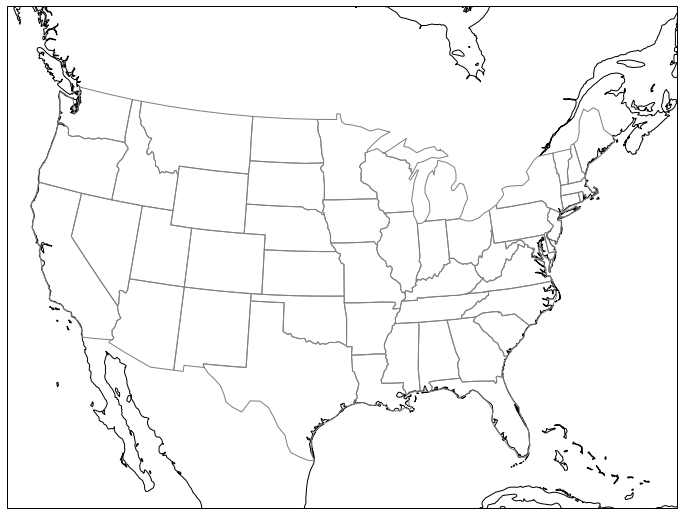

In [323]:
fig = plt.figure(figsize=[12,12])

ax1,x,y = Map_CONUS(1,1,1,lon,lat)
cs=ax1.contourf(x,y,np.transpose(counts_spatialfilt),np.linspace(0,1,1),cmap='Blues',transform=PC,extend='both')
# ax1.text(.4, 0.85, 'Average relative tornado\nprobability in MAM', va='bottom', ha='center',
#         rotation='horizontal',fontsize=24,transform=ax1.transAxes)

cbaxes = fig.add_axes([0.2, 0.17, 0.6, 0.02])
cb = plt.colorbar(cs,orientation='horizontal', cax=cbaxes)
cb.set_ticks([])
# cb.ax.set_xlabel('m s$^-$$^1$',fontsize=16)
# cb.ax.tick_params(labelsize=14)

plt.show()